In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tflite_support import metadata as _metadata

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Prepare training and validation datasets

In [2]:
batch_size = 32
img_height = 180
img_width = 180

directory = "./IMAGES"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

Found 900 files belonging to 6 classes.
Using 720 files for training.
Found 900 files belonging to 6 classes.
Using 180 files for validation.


In [3]:
class_names = train_ds.class_names

print("Class names: " + str(class_names))
with open("labelmap.txt", "w") as f:
    for c in class_names:
        f.write(c)
        f.write('\n')

Class names: ['1', '10', '2', '20', '5', '50']


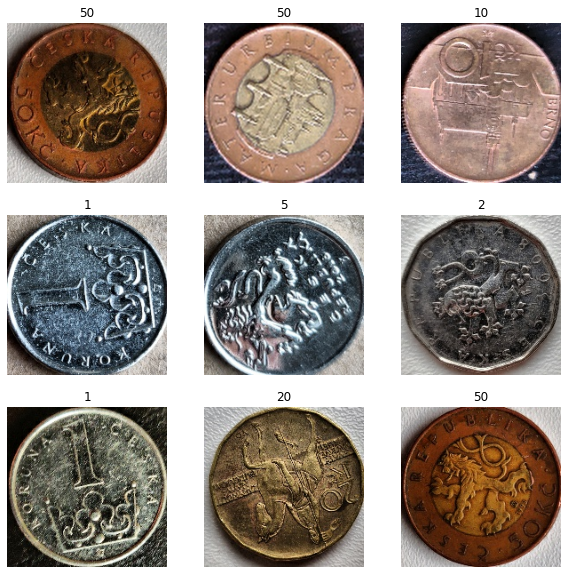

In [4]:
images, labels = next(iter(train_ds.skip(3).take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize for performance

`Dataset.cache()` - to keep the images in memory after they're loaded off disk during the first epoch

`Dataset.prefetch()` - overlaps data preprocessing and model execution while training

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize the dataset

`[0, 255] -> [0, 1]`

In [6]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

## Data augmentation

<!--
 - randomly rotate in the interval [0, 180] degrees
-->
 - randomly flip horizontally

In [7]:
data_augmentation_layer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.5),
    ]
)

## Create the model

In [8]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

## Train the model

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [10]:
epochs=100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    #callbacks=[callbacks]
)

Epoch 1/100
23/23 [==============================] - 9s 362ms/step - loss: 1.7764 - accuracy: 0.1898 - val_loss: 23.3717 - val_accuracy: 0.3500
Epoch 2/100
23/23 [==============================] - 8s 365ms/step - loss: 1.5664 - accuracy: 0.3294 - val_loss: 70.3789 - val_accuracy: 0.4000
Epoch 3/100
23/23 [==============================] - 8s 349ms/step - loss: 1.3343 - accuracy: 0.3898 - val_loss: 60.7960 - val_accuracy: 0.4444
Epoch 4/100
23/23 [==============================] - 12s 513ms/step - loss: 1.2790 - accuracy: 0.4597 - val_loss: 107.1264 - val_accuracy: 0.4167
Epoch 5/100
23/23 [==============================] - 11s 499ms/step - loss: 1.1868 - accuracy: 0.4515 - val_loss: 56.6707 - val_accuracy: 0.6222
Epoch 6/100
23/23 [==============================] - 12s 524ms/step - loss: 1.1238 - accuracy: 0.6050 - val_loss: 103.2184 - val_accuracy: 0.5778
Epoch 7/100
23/23 [==============================] - 13s 554ms/step - loss: 0.9974 - accuracy: 0.6737 - val_loss: 86.5954 - val_acc

23/23 [==============================] - 8s 349ms/step - loss: 0.1601 - accuracy: 0.9455 - val_loss: 51.1514 - val_accuracy: 0.8778
Epoch 58/100
23/23 [==============================] - 8s 349ms/step - loss: 0.1602 - accuracy: 0.9413 - val_loss: 70.2847 - val_accuracy: 0.8389
Epoch 59/100
23/23 [==============================] - 8s 349ms/step - loss: 0.1475 - accuracy: 0.9537 - val_loss: 78.5671 - val_accuracy: 0.8444
Epoch 60/100
23/23 [==============================] - 8s 350ms/step - loss: 0.1527 - accuracy: 0.9421 - val_loss: 56.7120 - val_accuracy: 0.8500
Epoch 61/100
23/23 [==============================] - 8s 351ms/step - loss: 0.1260 - accuracy: 0.9620 - val_loss: 50.1626 - val_accuracy: 0.8667
Epoch 62/100
23/23 [==============================] - 8s 350ms/step - loss: 0.1271 - accuracy: 0.9559 - val_loss: 81.5439 - val_accuracy: 0.8444
Epoch 63/100
23/23 [==============================] - 8s 348ms/step - loss: 0.1174 - accuracy: 0.9704 - val_loss: 48.3252 - val_accuracy: 0.872

## Visualize training results

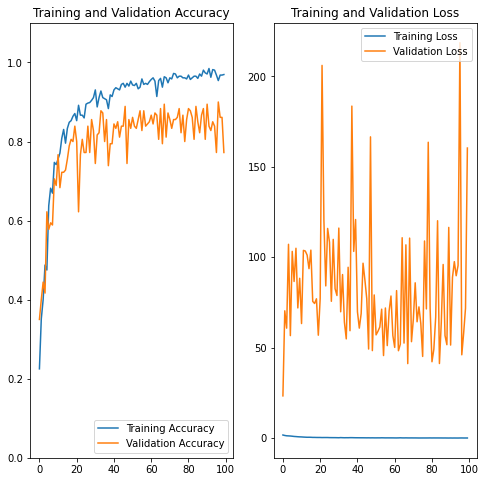

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0,1.1])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

[[7.0236774e-06 1.5648641e-01 1.5540443e-05 8.1308788e-01 7.9058213e-05
  3.0324139e-02]]
Predicted: 20 with a 81.31% confidence.
Correct: 10


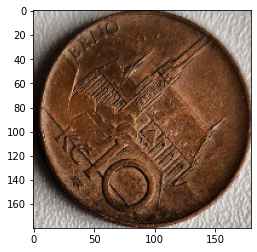

In [12]:
import random

class_num = 1

# get image path
img_dir_path = directory + "/" + str(class_names[class_num])
img_dir = [f for f in os.listdir(img_dir_path) if os.path.isfile(img_dir_path + "/" + f)]
img_name = img_dir[random.randint(0, len(img_dir)-1)]
img_path = img_dir_path + "/" + img_name

# load image
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)/255.
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

# predict
predictions = model.predict(img_array_batch)

print(predictions)

# show results
plt.imshow(img_array)

print(
    "Predicted: {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

print("Correct: " + str(class_names[class_num]))

## Export to .tflite

In [13]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpq5zthhb2/assets
